In [1]:
!kaggle datasets download -d davi1990/virtual-dissection
!unzip virtual-dissection.zip 
!rm virtual-dissection.zip 

# @title Download Data

Downloading...
From (original): https://drive.google.com/uc?id=1AOIJWz3-kfiUJ9f1u7dHr3atr_zVUEh0
From (redirected): https://drive.google.com/uc?id=1AOIJWz3-kfiUJ9f1u7dHr3atr_zVUEh0&confirm=t&uuid=7a3503fe-25f8-43f7-ace0-f60e7b835459
To: /content/virtual_dissection.zip
100%|██████████| 746M/746M [00:07<00:00, 104MB/s]


Archive:  /content/virtual_dissection.zip
  inflating: dist_Schaefer_1000parcels_7net.pkl  
  inflating: eeg_template.fif        
  inflating: model_results.npy       


In [2]:
import sys
!{sys.executable} -m pip install mne > /dev/null
!{sys.executable} -m pip install nilearn > /dev/null
!{sys.executable} -m pip install nibabel > /dev/null

# @title Install dependencies

In [3]:
#python stuffs
import pickle
import numpy as np
import glob
import re
import os
import scipy, sklearn
import numpy as np
import os.path as op
import pandas as pd
from scipy.signal import find_peaks



# plotting stuffs
import matplotlib.pyplot as plt
import seaborn as sns

#neuroimaging stuffs
import mne
import nibabel as nib
from nilearn import plotting
from nilearn import surface
from nilearn.image import load_img


import warnings
warnings.filterwarnings('ignore')


# @title Importage


In [8]:
url = 'https://github.com/Davi1990/DissNet/raw/main/examples/network_colour.xlsx'
colour = pd.read_excel(url, header=None)[4]
template_eeg = mne.read_epochs('eeg_template.fif', verbose=False)

model_results =np.load('model_results.npy', allow_pickle=True).item()

with open('dist_Schaefer_1000parcels_7net.pkl', 'rb') as handle:
    stim_region = pickle.load(handle)
stim_region = stim_region['stim_region']

networks = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
# Create a dictionary to store the network indices
stim_network_indices = {network: [] for network in networks}
for i, label in enumerate(stim_region):
    # Iterate over each network
    for network in networks:
        if network in label:
            stim_network_indices[network].append(i)
            break

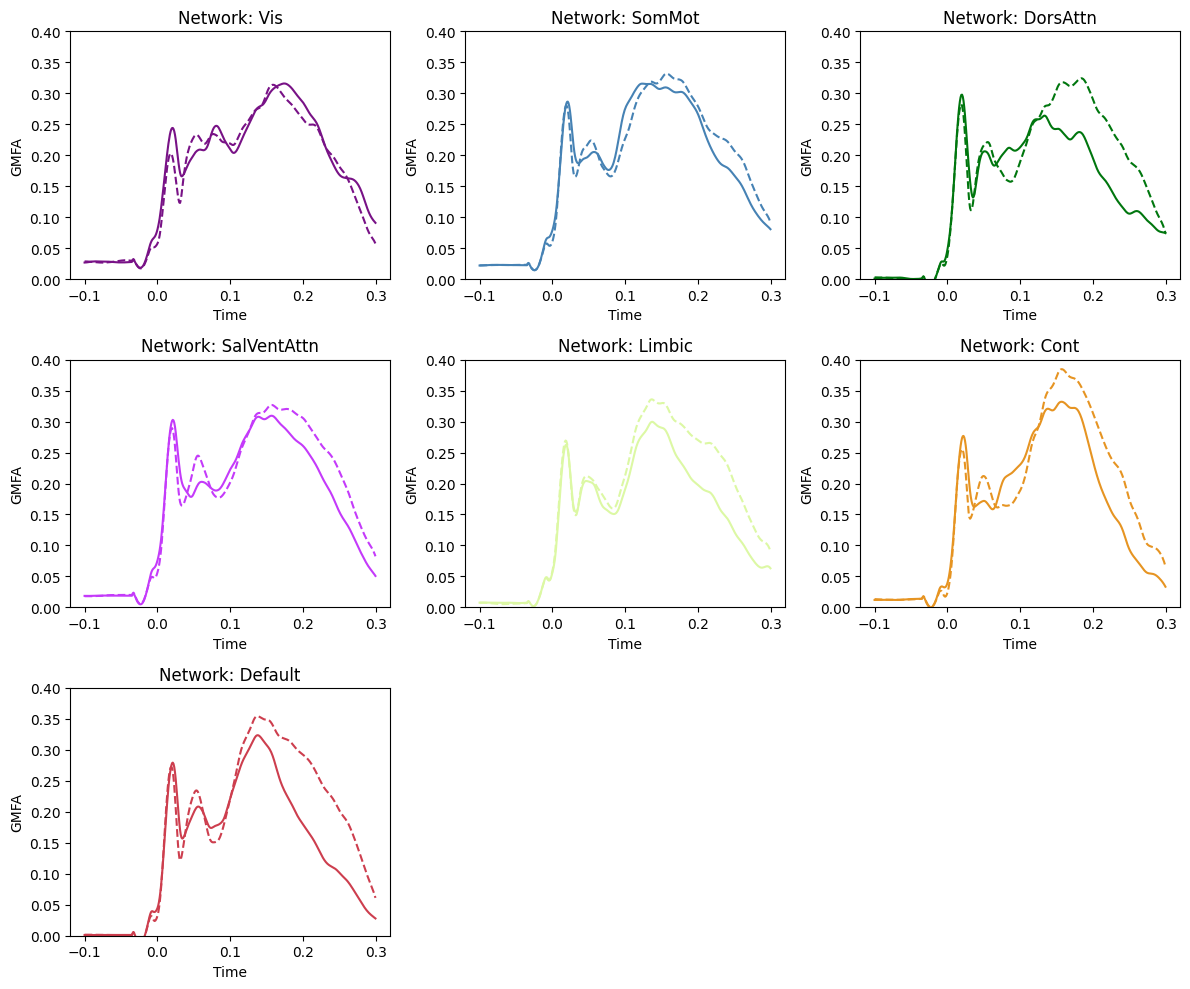

In [14]:
# Calculate the number of subplots needed
num_plots = len(networks)
num_rows = 3
num_cols = (num_plots + num_rows - 1) // num_rows

# Set the size of the figure
fig_width = 12  # Adjust as needed
fig_height = 10  # Adjust as needed
plt.figure(figsize=(fig_width, fig_height))

# Loop over networks
for i, network in enumerate(networks):
    # Create subplots
    plt.subplot(num_rows, num_cols, i + 1)

    # Plot standard deviation of EEG test data
    plt.plot(template_eeg.times[200:600], np.mean(np.std(model_results['eeg_test'][stim_network_indices[network]], axis=1), axis=0) - .1,
             color=colour[i], linestyle='--', label='eeg_test')

    # Plot standard deviation of EEG test lesion data
    plt.plot(template_eeg.times[200:600], np.mean(np.std(model_results['eeg_test_lesion'][stim_network_indices[network]], axis=1), axis=0) -.1,
             color=colour[i], label='eeg_test_lesion')

    plt.ylim(0, 0.4)

    # Add title, labels, and legend
    plt.title(f'Network: {network}')
    plt.xlabel('Time')
    plt.ylabel('GMFA')


# Adjust layout to prevent overlap
plt.tight_layout()


# Show the plot
plt.show()


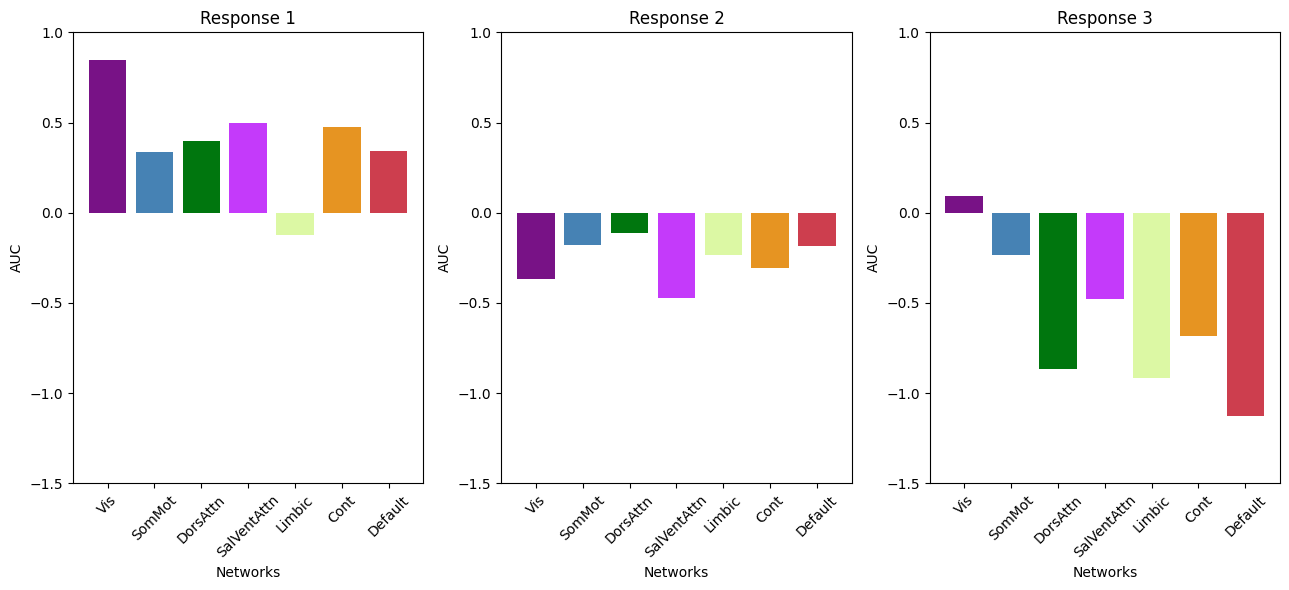

In [19]:
windows = 3

AUC_original = np.zeros((3,model_results['eeg_test_lesion'].shape[0]))
AUC_simulation = np.zeros((3,model_results['eeg_test_lesion'].shape[0]))

for ses in range(model_results['eeg_test_lesion'].shape[0]):

    original_ts = np.std(model_results['eeg_test'][ses], axis=0)

    AUC_original[0, ses] = np.trapz(original_ts[100:137] - np.mean(original_ts[:100]), dx=5)
    AUC_original[1, ses] = np.trapz(original_ts[137:178] - np.mean(original_ts[:100]), dx=5)
    AUC_original[2, ses] = np.trapz(original_ts[178:397] - np.mean(original_ts[:100]), dx=5)


    lesion_ts = np.std(model_results['eeg_test_lesion'][ses], axis=0)

    AUC_simulation[0, ses] = np.trapz(lesion_ts[100:137] - np.mean(lesion_ts[:100]), dx=5)
    AUC_simulation[1, ses] = np.trapz(lesion_ts[137:178] - np.mean(lesion_ts[:100]), dx=5)
    AUC_simulation[2, ses] = np.trapz(lesion_ts[178:397] - np.mean(lesion_ts[:100]), dx=5)


AUC_original[0,:] = AUC_original[0,:] / 37
AUC_original[1,:] = AUC_original[1,:] / 45
AUC_original[2,:] = AUC_original[2,:] / 322

AUC_simulation[0,:] = AUC_simulation[0,:] / 37
AUC_simulation[1,:] = AUC_simulation[1,:] / 45
AUC_simulation[2,:] = AUC_simulation[2,:] / 322


net_AUC_orig = {}
net_AUC_lesion = {}

for network in networks:
    net_AUC_orig[network] = AUC_original[:,stim_network_indices[network]]
    net_AUC_lesion[network] = AUC_simulation[:,stim_network_indices[network]]


AUC_averages_original = np.zeros((len(networks), windows))
AUC_averages_lesion = np.zeros((len(networks), windows))

for idx, key in enumerate(net_AUC_orig.keys()):
    AUC_averages_original[idx, :] = np.mean(net_AUC_orig[key], axis=1)
    AUC_averages_lesion[idx, :] = np.mean(net_AUC_lesion[key], axis=1)


AUC_averages_lesion = AUC_averages_lesion #*100000
AUC_averages_original = AUC_averages_original #*100000




# Create the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(13, 6))  # 1 row, 3 columns

# Plotting the data on each subplot
for i in range(3):
    axs[i].bar(range(AUC_averages_original.shape[0]), 5 * (AUC_averages_lesion[:, i] - AUC_averages_original[:, i]), color=colour)
    axs[i].set_xticks(range(AUC_averages_original.shape[0]))
    axs[i].set_xticklabels(networks, rotation=45)
    axs[i].set_xlabel('Networks')
    axs[i].set_ylabel('AUC')
    axs[i].set_title(f'Response {i+1}')
    axs[i].set_ylim(-1.5, 1)  # Adjust the y-axis limits as needed

# Adjust layout
plt.tight_layout()


plt.show()

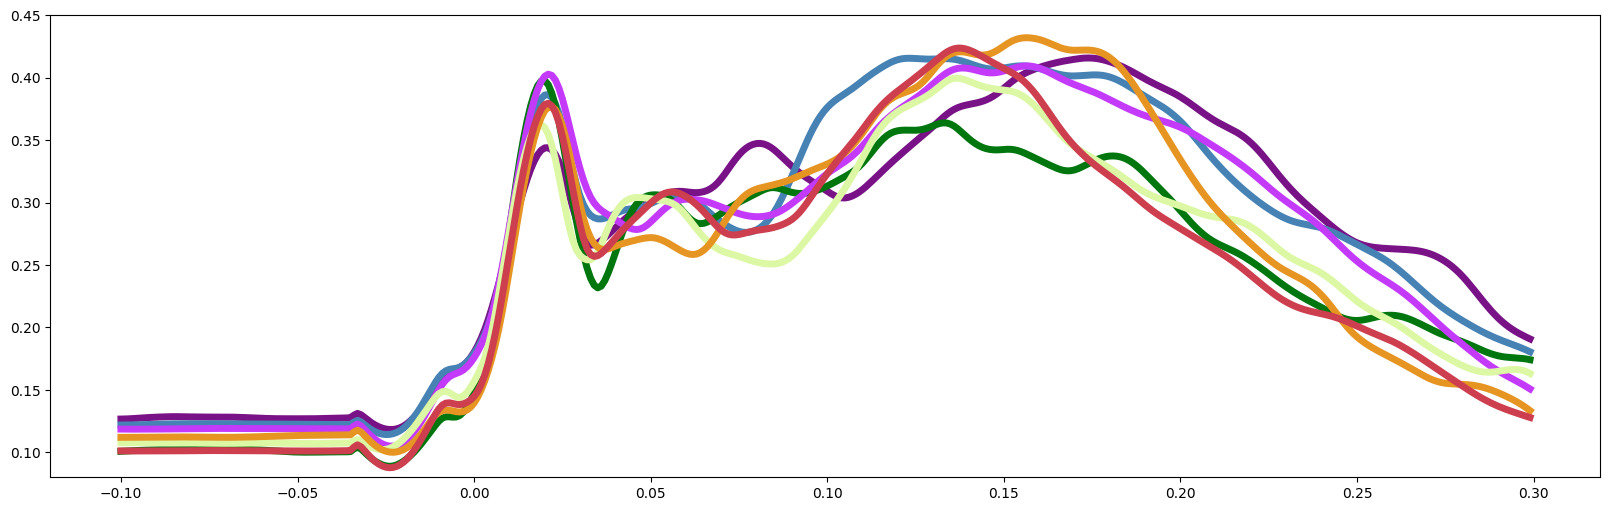

In [21]:

all_lesioned_gfma = np.zeros((model_results['eeg_test'].shape[0], model_results['eeg_test'].shape[2]))
all_original_gfma = np.zeros((model_results['eeg_test'].shape[0], model_results['eeg_test'].shape[2]))



for ses in range(model_results['I_test_lesion'].shape[0]):
        ts2use = (model_results['eeg_test_lesion'] )[ses,:,:]
        all_lesioned_gfma[ses,:] =  np.std(ts2use, axis=0)
        all_original_gfma[ses,:] =  np.std((model_results['eeg_test'] )[ses,:,:]  , axis=0)


net_lesioned_gfma = {}

for network in networks:
    net_lesioned_gfma[network] = all_lesioned_gfma[stim_network_indices[network]]


averages_lesioned = []

for key, value in net_lesioned_gfma.items():
    average_lesioned = sum(value) / len(value)
    averages_lesioned.append(average_lesioned)

averages_lesioned = np.array(averages_lesioned)

# Download the file from the GitHub URL
url = 'https://github.com/Davi1990/DissNet/raw/main/examples/network_colour.xlsx'
colour = pd.read_excel(url, header=None)[4]


fig = plt.figure(figsize=(20, 6))

# Plot the data
for net in range(len(networks)):
    plt.plot(template_eeg.times[200:600], averages_lesioned[net, :], colour[net], linewidth=5)

    #plt.plot(a.times[200:600], averages_lesioned[net, :]- np.mean(averages_lesioned[net, :100]), colour[net], linewidth=5)
    plt.ylim([0.08,0.45])
# Display the plot

plt.show()

